<a href="https://colab.research.google.com/github/adelelwan24/Prediction-of-Obesity-Risk/blob/main/Multi_Class_Prediction_of_Obesity_Risk(train%2Boriginal).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install xgboost
!pip install lightbm
!pip install catboost
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_predict,RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder , StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

import warnings
warnings.filterwarnings("ignore")
# Disable LightGBM warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
train_sample=pd.read_csv("train.csv")

In [4]:
train_orgin_extra=pd.read_csv("ObesityDataSet.csv")

In [5]:
train = pd.concat([train_sample, train_orgin_extra], ignore_index=True)

In [6]:
test=pd.read_csv("test.csv")

# **Exploratory Data Analysis (EDA)**

In [7]:
sns.set_palette('YlOrBr')

In [8]:
def HeatmapPlot(df, figsize=(10, 10), threshold=0, vmin=-1, vmax=1, center=0, digit=False):
    plt.figure(figsize=figsize)
    if digit:
        fmt='d'
    else:
        fmt='.2f'

    mask = ~(np.tril(np.ones_like(df, dtype=bool)) & (abs(df) > threshold))

    sns.heatmap(df, annot=True, fmt=fmt, linewidths=1,
                linecolor='k', vmin=vmin, vmax=vmax, mask=mask,
                square=True, cmap='RdBu', center=center, cbar_kws={'shrink' : .5})

In [9]:
def Bar(df,Column_name,bins):
  plt.figure(figsize=(15,4))
  freq, bins, p = plt.hist(df[Column_name], bins=bins, rwidth=0.9)

  # x coordinate for labels
  bin_centers = np.diff(bins)*0.5 + bins[:-1]

  n = 0
  for fr, x, patch in zip(freq, bin_centers,p):
    height = int(freq[n])
    plt.annotate("{}%".format(round(height*100 / df.shape[0],2)),
                xy = (x, height),
                xytext = (0,0.2),
                textcoords = "offset points",
                ha = 'center', va = 'bottom'
                )
    n = n+1
  plt.grid()
  plt.xticks(bins)
  plt.title(Column_name)
  plt.show;

***i) Simple Analysis***



In [10]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0.0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1.0,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2.0,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3.0,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4.0,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [11]:
train.shape

(22869, 18)

In [12]:
train.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000
mean,10378.50000,23.885263,1.700377,87.767610,2.443428,2.754344,2.027442,0.984382,0.620551
std,5992.46278,5.753419,0.087881,26.364243,0.533329,0.712711,0.608901,0.839466,0.602850
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631662,66.000000,2.000000,3.000000,1.755907,0.015860,0.000000
50%,10378.50000,22.815416,1.700000,84.000000,2.392665,3.000000,2.000000,1.000000,0.579541
75%,15567.75000,26.000000,1.763029,111.531208,3.000000,3.000000,2.535127,1.596576,1.000000
max,20757.00000,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


- Note that there are differences in the scale of the data, so we need to perform scaling.

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22869 entries, 0 to 22868
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  float64
 1   Gender                          22869 non-null  object 
 2   Age                             22869 non-null  float64
 3   Height                          22869 non-null  float64
 4   Weight                          22869 non-null  float64
 5   family_history_with_overweight  22869 non-null  object 
 6   FAVC                            22869 non-null  object 
 7   FCVC                            22869 non-null  float64
 8   NCP                             22869 non-null  float64
 9   CAEC                            22869 non-null  object 
 10  SMOKE                           22869 non-null  object 
 11  CH2O                            22869 non-null  float64
 12  SCC                             

- There are some columns with object type, so we need to perform encoding.

In [14]:
train.drop('id', axis=1, inplace=True)

In [15]:
train.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

- There is no missing data.

In [16]:
train.duplicated().sum()

24

- There is  duplicated data , we should drop them

In [17]:
train = train.drop_duplicates()

In [18]:
train.duplicated().sum()

0

In [19]:
train.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

 ***ii) Visual Analysis***

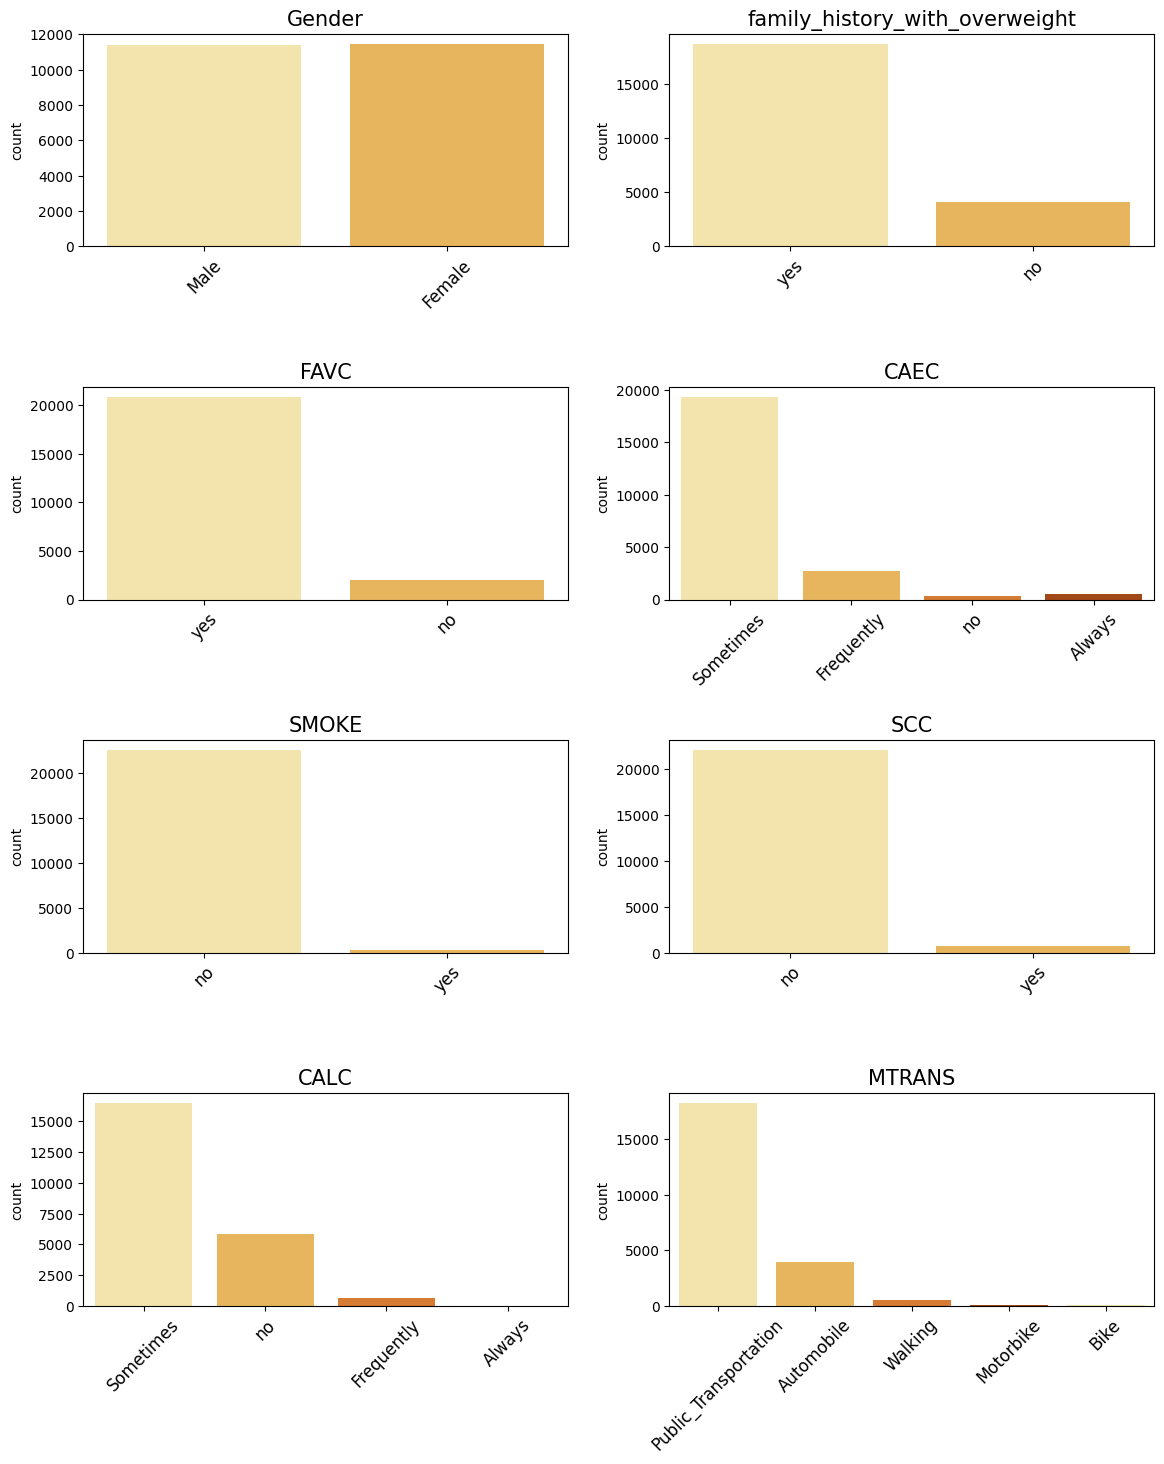

In [20]:
categorical_features = train.select_dtypes(include=['O']).columns.tolist()
categorical_features.remove('NObeyesdad')

fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(12, 15))

axs = axs.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(data=train,x=feature,ax=axs[i],palette=sns.color_palette('YlOrBr', 4))
    axs[i].set_xticklabels(labels=axs[i].get_xticklabels(), rotation=45, fontsize=12)
    axs[i].set_xlabel('')
    axs[i].set_title(feature, fontsize=15)

plt.tight_layout(pad=2)
plt.show()

- There are no balance between categories in the same feature.

- The majority of people consume large quantities of food that are high in calories (FAVC).

- Most individuals consume food between meals (CAEC) sometimes.

- We observe a significant difference in the prevalence of smoking among individuals, with varying proportions of smokers and non-smokers. The same pattern is noted for the SCC (Self-Care Commitment) feature.

- Most individuals consume alcoholic beverages (CALC) sometimes.

- As the vast majority of individuals opt for public transportation as their primary mode of commuting, we will delve deeper into the MTRANS feature by examining the distribution of weight classifications.



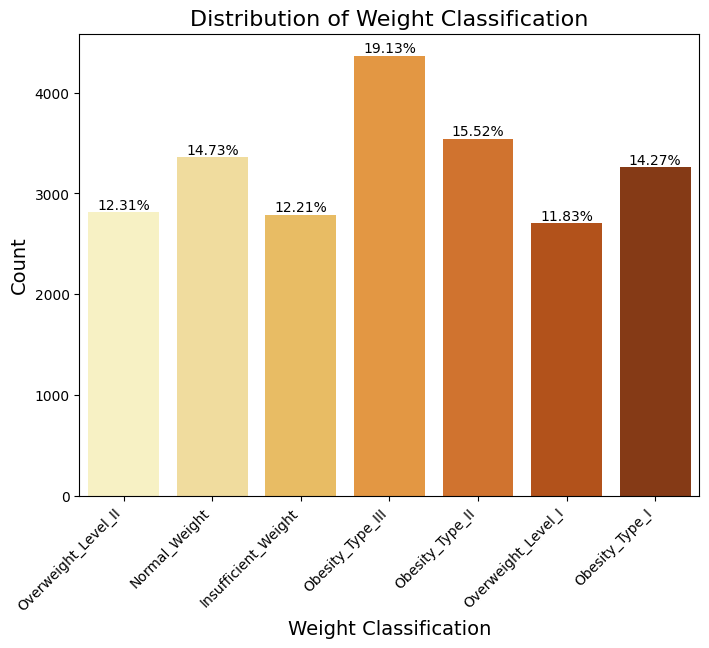

In [21]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='NObeyesdad', data=train, palette='YlOrBr')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Calculate percentage and annotate each bar
total_height = len(train)
for p in ax.patches:
    height = p.get_height()
    percentage = round((height / total_height) * 100, 2)
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 0.2,
            '{}%'.format(percentage),
            ha='center', va='bottom')

plt.title('Distribution of Weight Classification', fontsize=16)
plt.xlabel('Weight Classification', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

- We notice a relatively balanced distribution across all classes, with "Obesity_Type_III" being the highest . This is good as there will not likely be a bias towards any class during model training for prediction.

In [22]:
current_palette = sns.color_palette('YlOrBr', 7)
current_palette

[(0.9999846212995002, 0.968319876970396, 0.7365936178392927),
 (0.996078431372549, 0.8892425990003844, 0.5665974625144176),
 (0.996078431372549, 0.766643598615917, 0.30805074971164936),
 (0.9949711649365629, 0.5974778931180315, 0.15949250288350636),
 (0.9230296039984621, 0.4364475201845444, 0.07704728950403691),
 (0.7952941176470588, 0.2958246828143022, 0.008027681660899655),
 (0.5945098039215686, 0.20230680507497117, 0.01590157631680123)]

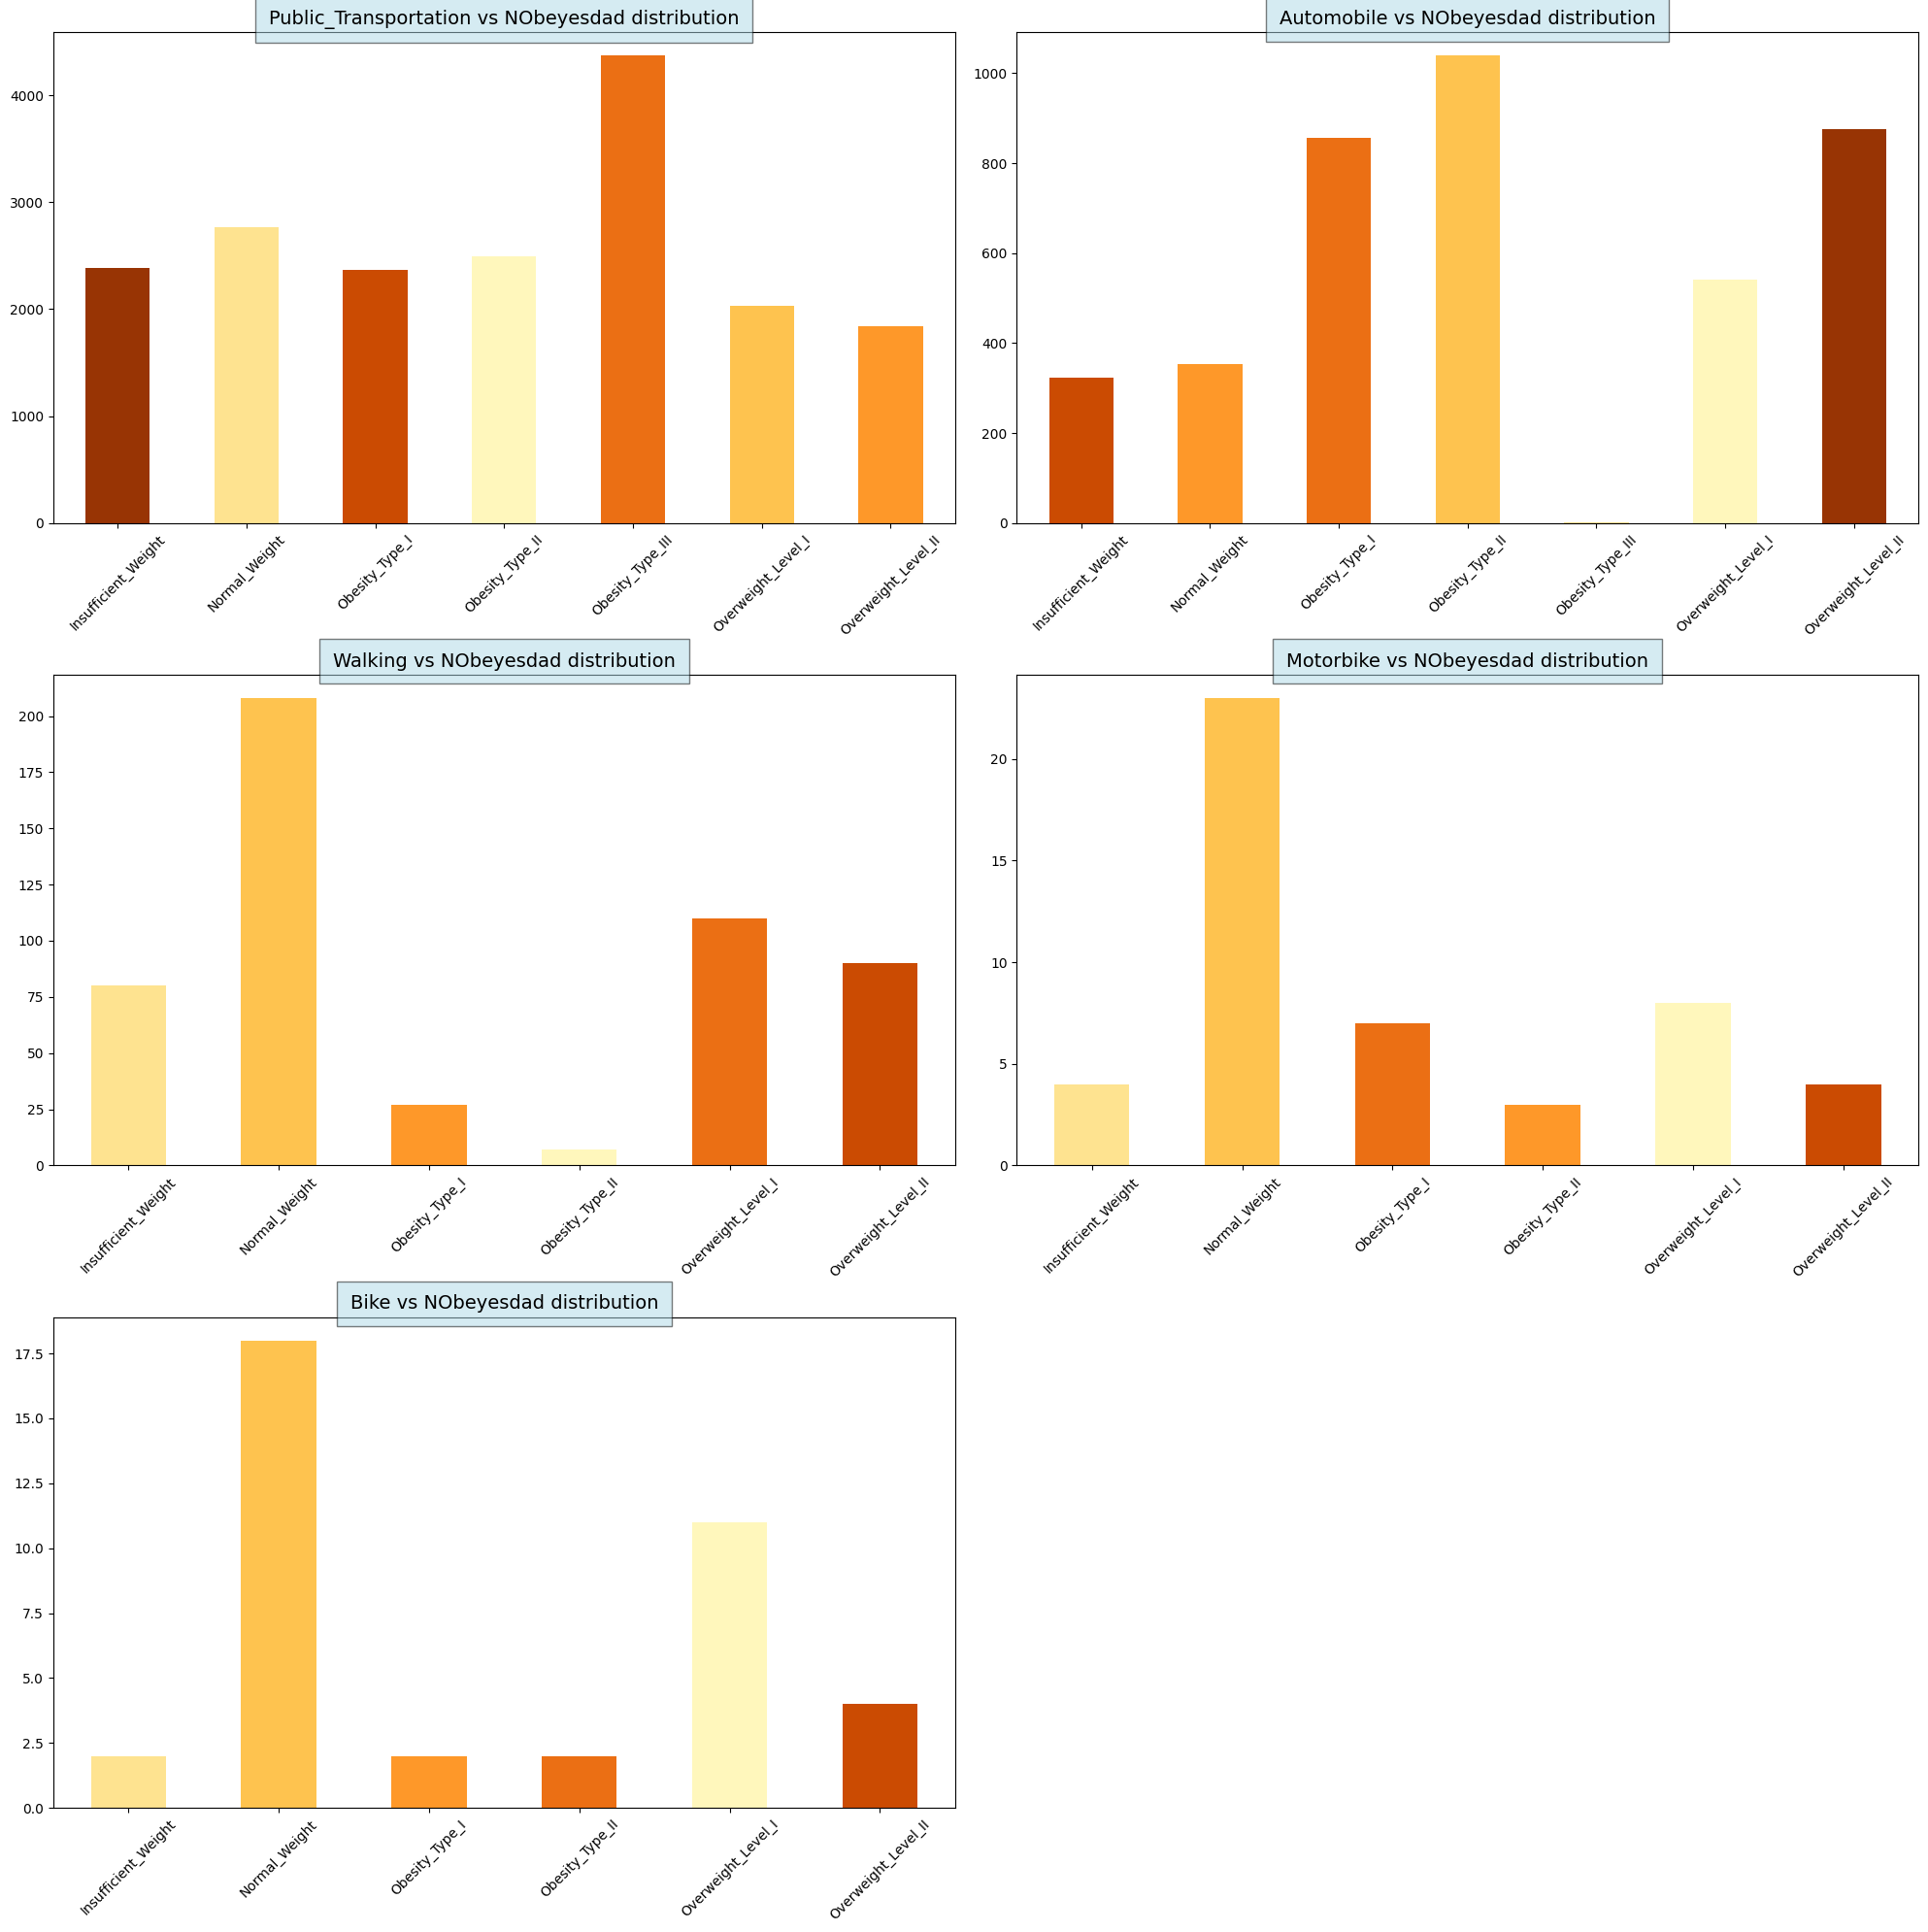

In [23]:
color_map = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

public_trans = train[train.MTRANS == 'Public_Transportation'].NObeyesdad.value_counts()
automobile_trans = train[train.MTRANS == 'Automobile'].NObeyesdad.value_counts()
walking_trans = train[train.MTRANS == 'Walking'].NObeyesdad.value_counts()
motorbike_trans = train[train.MTRANS == 'Motorbike'].NObeyesdad.value_counts()
bike_trans = train[train.MTRANS == 'Bike'].NObeyesdad.value_counts()

fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axs = axs.flatten()

features = [public_trans, automobile_trans, walking_trans, motorbike_trans, bike_trans]
feature_values = ['Public_Transportation', 'Automobile', 'Walking', 'Motorbike', 'Bike']

for i, feature in enumerate(features):
    colors = [current_palette[color_map.get(x, 0)] for x in feature.index]
    feature = feature.sort_index()
    feature.plot(kind='bar', color=colors, ax=axs[i], sort_columns=False, rot=45)
    axs[i].set_title(f'{feature_values[i]} vs NObeyesdad distribution', fontsize=14,
                     bbox={'facecolor': 'lightblue', 'alpha': 0.5, 'pad': 10})

axs[-1].axis('off')
plt.tight_layout()
plt.show()

# fig.savefig("comp.png", dpi=300, format='png', bbox_inches='tight')

- Individuals who use public transportation as their primary mode of commuting exhibit a slightly higher prevalence of obesity compared to those who use other modes of transportation.


- Among individuals who use automobiles as their primary mode of transportation, there is a relatively even distribution of weight classifications, with a slightly higher proportion of individuals with normal weight.


- Walking as the primary mode of transportation appears to be associated with a lower prevalence of obesity compared to other modes of transportation.


- Motorbike and bike users show a similar distribution of weight classifications, with a relatively higher proportion of individuals with normal weight and a lower proportion of individuals with obesity.


- Overall, the analysis of the bar graphs suggests that the mode of transportation may have some association with weight classification, with public transportation users having a higher likelihood of obesity and walking users having a lower likelihood of obesity.

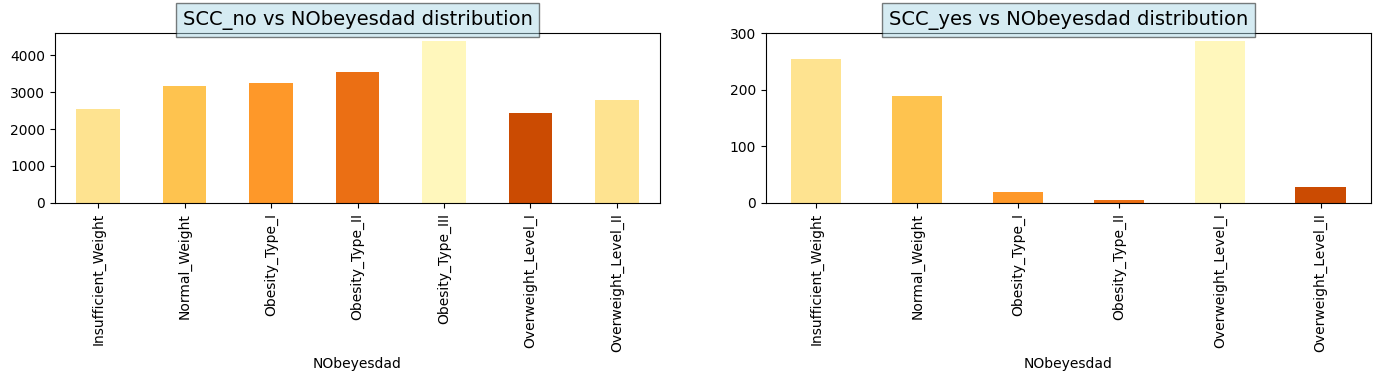

In [24]:
SCC_no = train[train.SCC == 'no']['NObeyesdad'].value_counts()
SCC_yes = train[train.SCC == 'yes']['NObeyesdad'].value_counts()
feature_values = ['SCC_no', 'SCC_yes']


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

for i, feature in enumerate([SCC_no, SCC_yes]):
    feature = feature.sort_index()
    feature.plot(kind='bar', color=colors, ax=axs[i])
    axs[i].set_title(f'{feature_values[i]} vs NObeyesdad distribution', fontsize=14,
                     bbox={'facecolor': 'lightblue', 'alpha': 0.5, 'pad': 5})
    axs[i].set_xlabel('NObeyesdad')

plt.tight_layout(pad=5)
plt.show()

- Individuals without SCC are more likely to be obese compared to those with SCC.

- This suggests that there may be an association between adherence to self-care and weight classification, with individuals with SCC having a lower risk of obesity.

<Figure size 1500x1200 with 0 Axes>

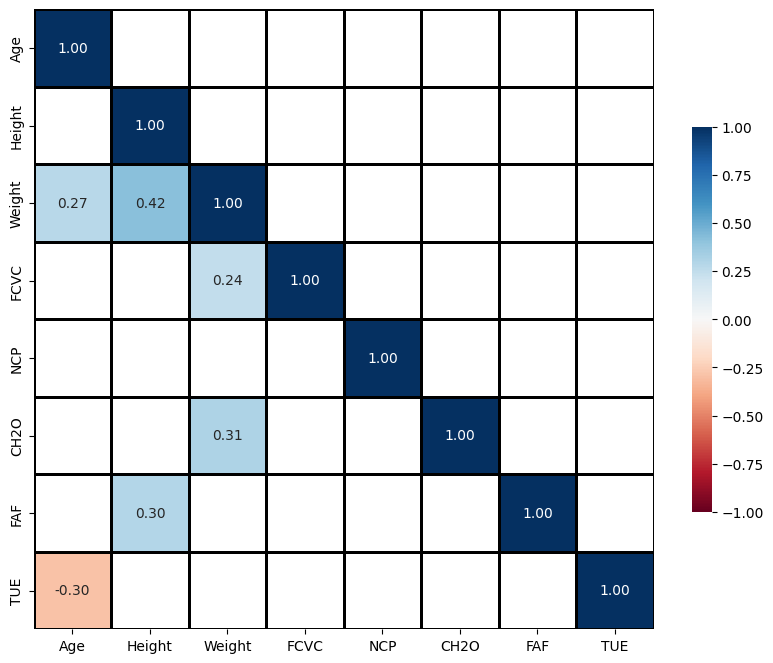

In [25]:
df_corr=train.select_dtypes(include=["float64","int64"]).corr()
plt.figure(figsize=(15,12))
# sns.heatmap(df_corr,annot=True,cmap="Blues",fmt=".2f");
HeatmapPlot(df_corr, threshold=.2);

- there are no correlation between features

In [26]:
def PlotBoxs(df, cols, ncols=1,figsize=(20, 10)):

    # plt.figure(figsize=figsize)
    nrows = len(cols) // ncols
    fig, ax = plt.subplots(nrows, ncols)
    fig.set_size_inches(figsize)
    ax = ax.flatten()
    for i, col in enumerate(cols):
        sns.boxplot(df, x=col, ax=ax[i], color='#e9c46a')
        ax[i].set_title(col.upper(), fontsize=20)
        ax[i].set_xlabel('')
    plt.tight_layout(pad=3)
    # fig.savefig("boxplots.png", dpi=300, format='png', bbox_inches='tight')

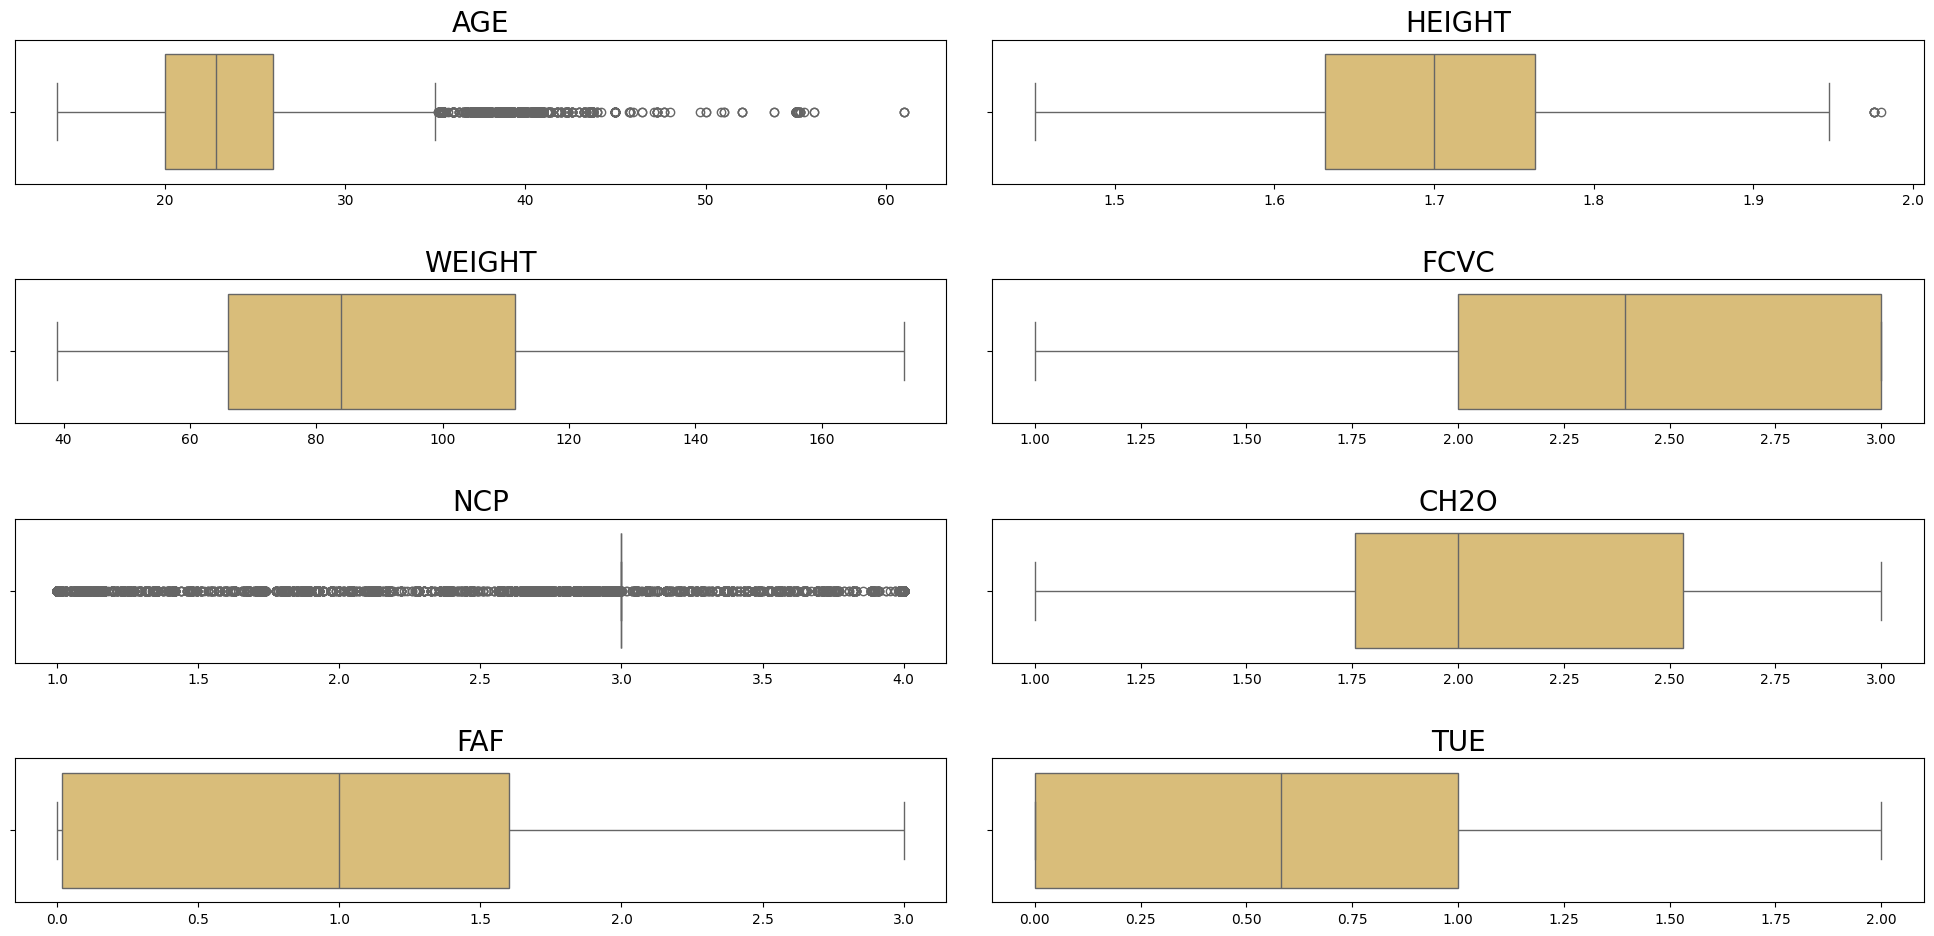

In [27]:
PlotBoxs(train, train.select_dtypes(include='number').columns.to_list(), 2)

- there are outliers in some features like Age & NCP

In [28]:
train.skew()

Age       1.584105
Height    0.012340
Weight    0.106606
FCVC     -0.364981
NCP      -1.517723
CH2O     -0.202765
FAF       0.504868
TUE       0.664557
dtype: float64

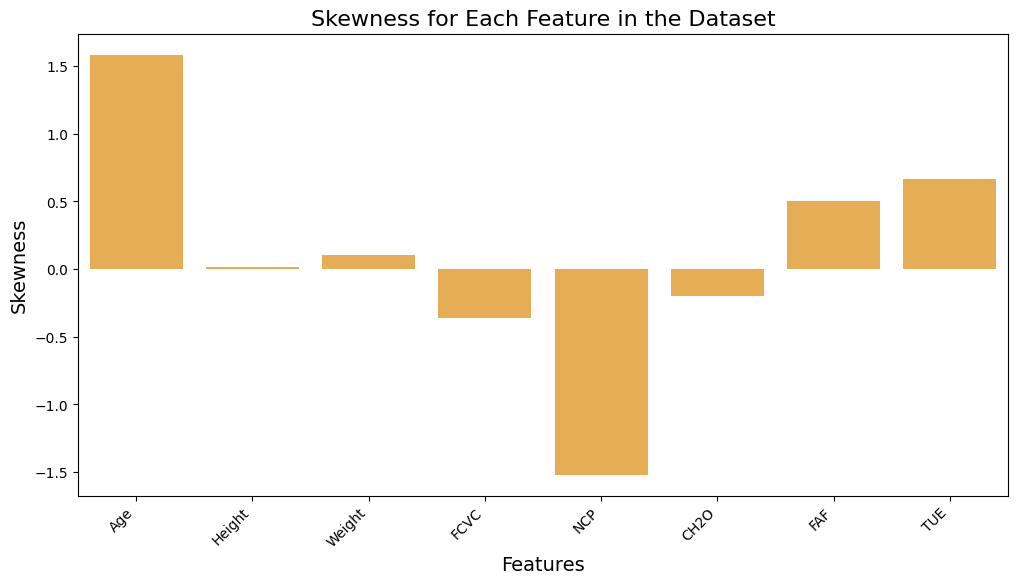

In [29]:
skew_values = train.skew()

plt.figure(figsize=(12, 6))
sns.barplot(x=skew_values.index, y=skew_values.values, color=sns.color_palette('YlOrBr')[2])
plt.title('Skewness for Each Feature in the Dataset', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Skewness', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

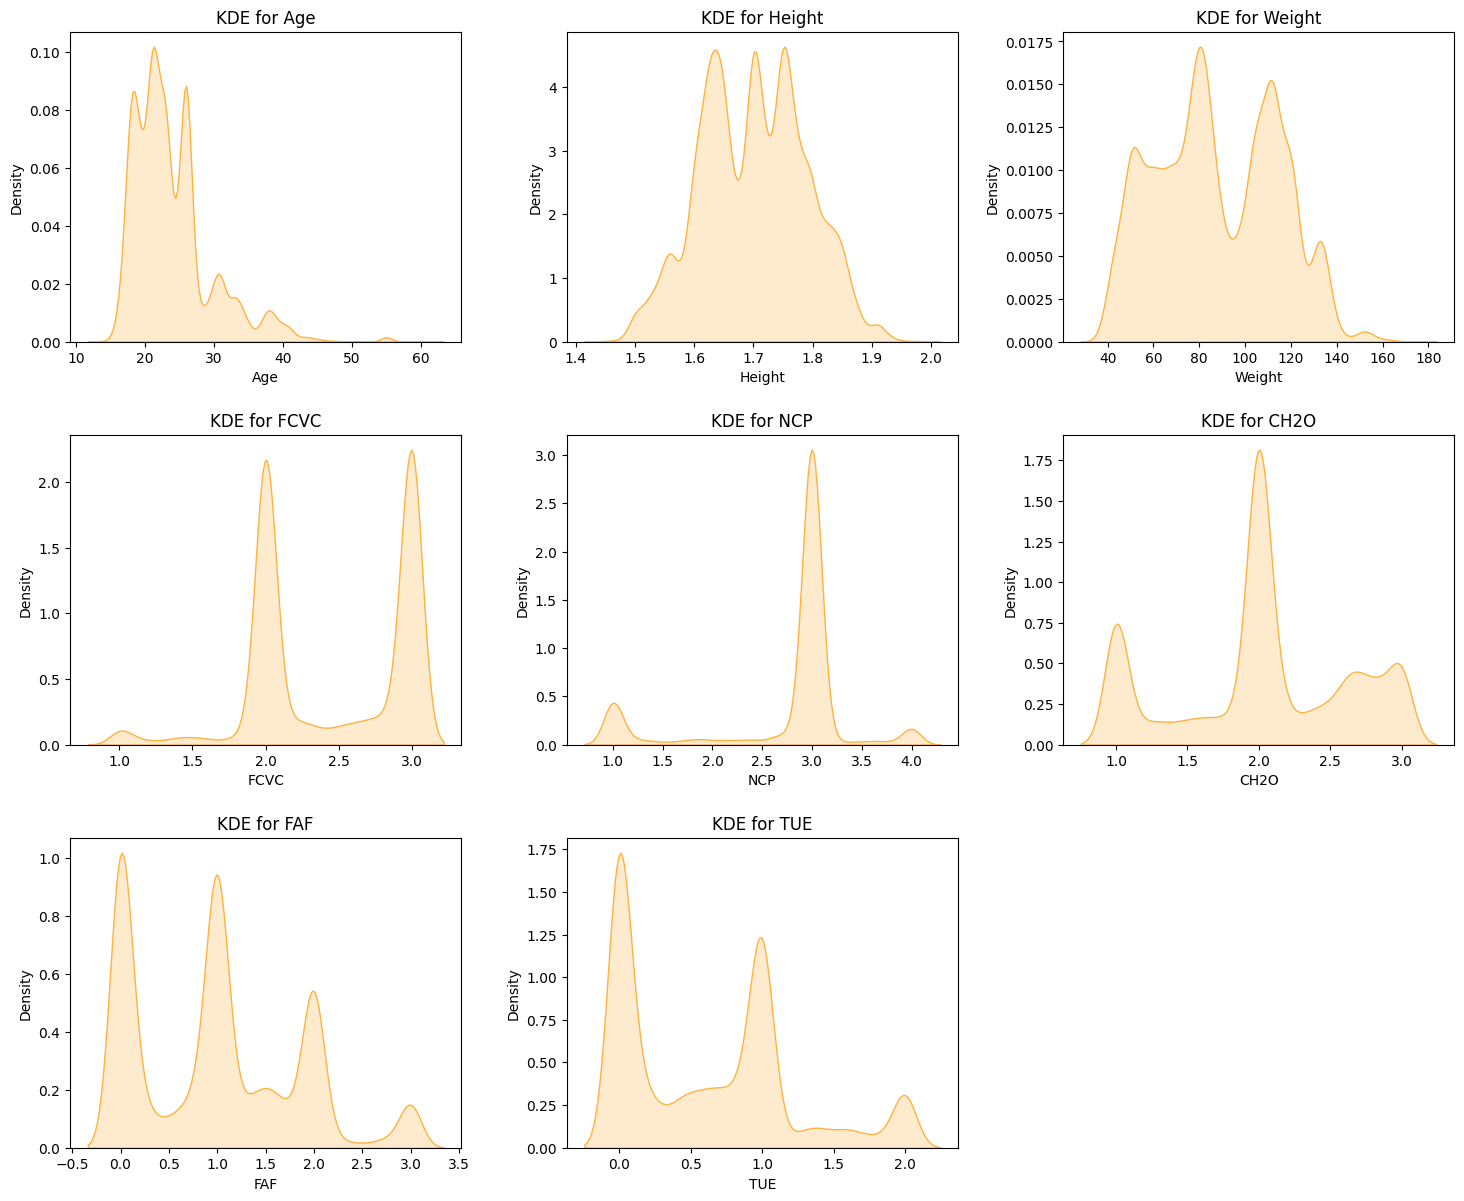

In [30]:
num_cols = train.select_dtypes(include='number').columns.to_list()
num_columns = len(train.columns)
num_rows = (num_columns + 3) // 4
plt.figure(figsize=(15, num_rows * 4))

for i, column in enumerate(num_cols, 1):
    # if pd.api.types.is_numeric_dtype(train[column].dtype):
    plt.subplot(num_rows, 3, i)
    sns.kdeplot(train[column], fill=True, color=sns.color_palette('YlOrBr')[2])
    plt.title(f'KDE for {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

plt.tight_layout(pad=2)
plt.show()

- There is right skew in feature "Age"= 1.58625
- there is left skew in feature "NCP"= -1.56225

In [31]:
cat_col = list(train.select_dtypes(include=['object']).columns)
if 'NObeyesdad' in cat_col:
    cat_col.remove('NObeyesdad')

In [32]:

# for i ,col in enumerate(cat_col):
#     fig = plt.figure()
#     sns.countplot(hue=col,x='NObeyesdad',data=train,
#                   palette=sns.color_palette('YlOrBr', 4))
#     plt.title(f'{col} vs NObeyesdad')
#     plt.ylabel('Count')
#     plt.tick_params(axis='x', rotation=75)
#     # fig.savefig(f"{col}.png", dpi=300, format='png', bbox_inches='tight')

# plt.tight_layout()
# plt.show()

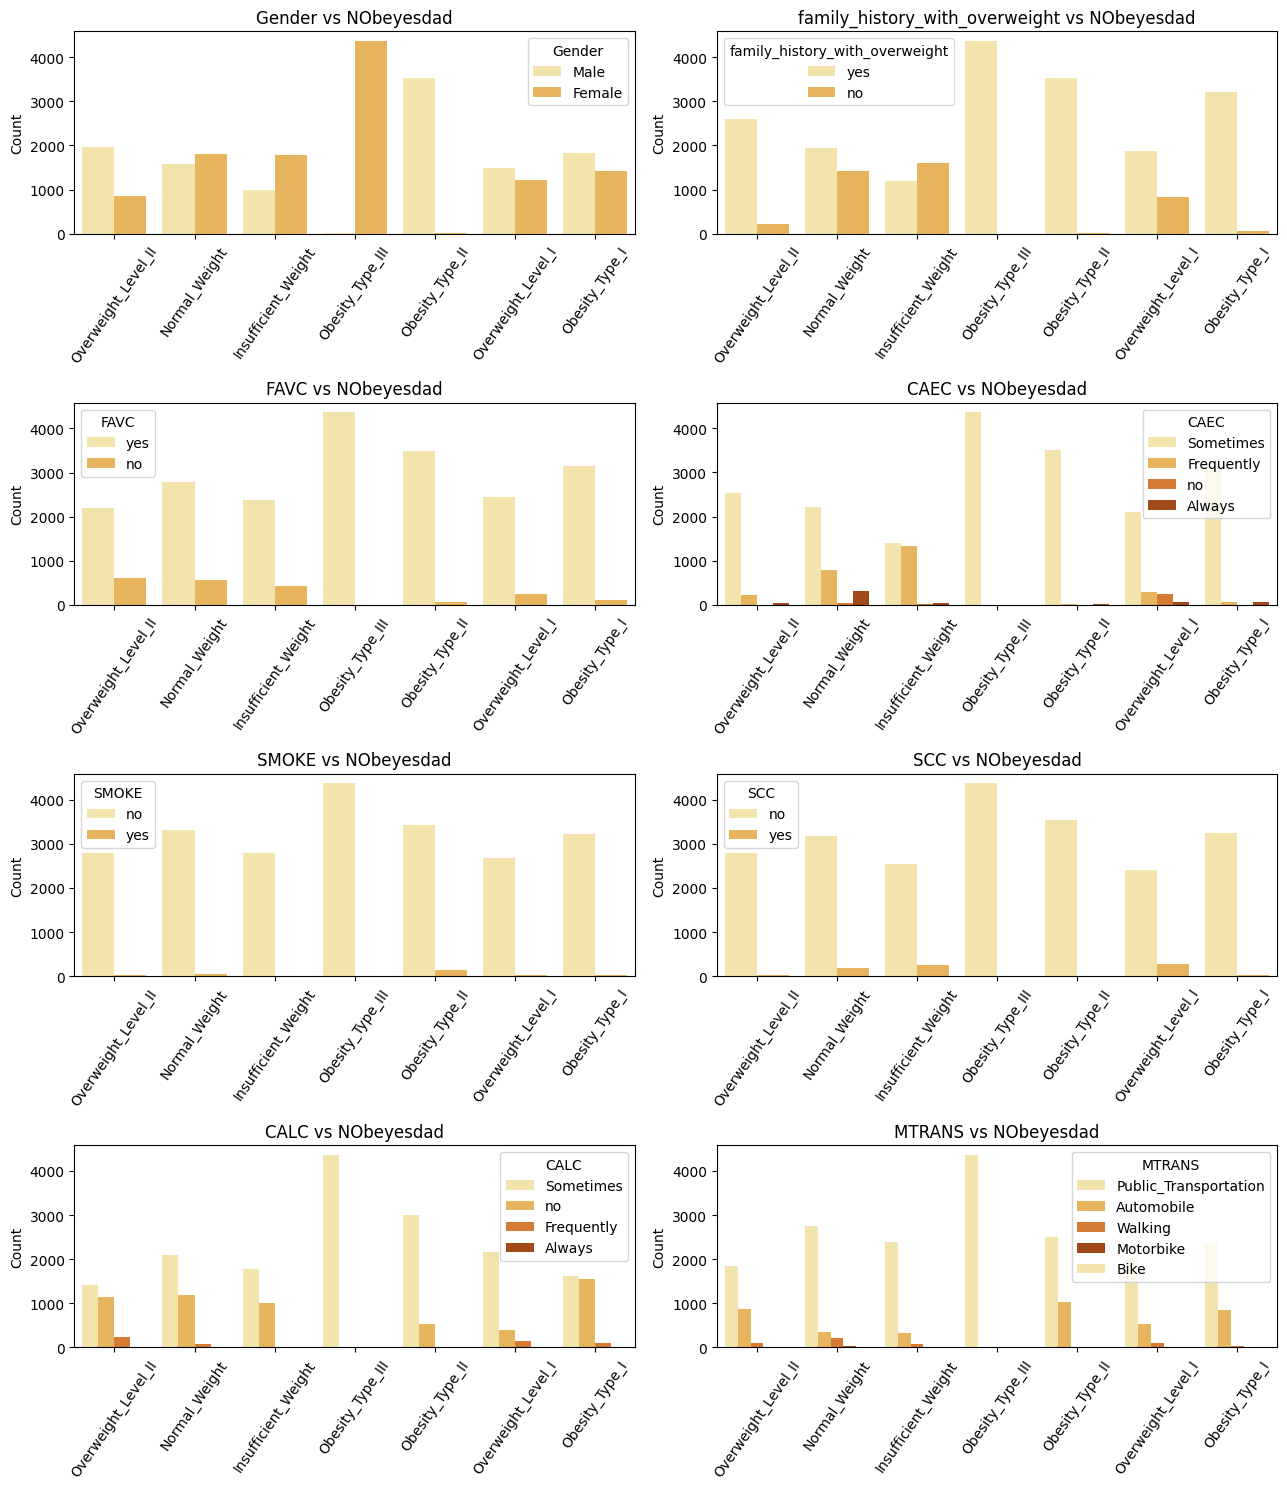

In [33]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 15))
axes = axes.flatten()
for i ,col in enumerate(cat_col):
    sns.countplot(hue=col,x='NObeyesdad',data=train,ax=axes[i],
                  palette=sns.color_palette('YlOrBr', 4))
    axes[i].set_title(f'{col} vs NObeyesdad')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=55)

plt.tight_layout()
plt.show()

- In general, women are more prone to obesity compared to men.
- If a person has a family history of overweight, their likelihood of experiencing obesity is higher.
- People who consume large quantities of high-calorie foods (FCVC) are more likely to experience obesity.
- People who consume snacks between meals(CAEC) sometimes are more likely to experience obesity.
- People who do not smoke are more likely to develop obesity compared to those who smoke.
- People who occasionally consume alcoholic beverages or drink sometimes are more likely to develop obesity.

# **4) Data Preparation**

In [34]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
categorical_columns = train.select_dtypes(include='object').columns
if 'NObeyesdad' in categorical_columns:
    categorical_columns = categorical_columns.drop(['NObeyesdad'])
train[categorical_columns] = ordinal_encoder.fit_transform(train[categorical_columns])

In [35]:
train[categorical_columns] = train[categorical_columns].astype(int)

In [36]:
lb=LabelEncoder()
train['NObeyesdad']=lb.fit_transform(train['NObeyesdad'])

In [37]:
train['NCP'] = train['NCP'].astype(int)

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22845 entries, 0 to 22868
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          22845 non-null  int64  
 1   Age                             22845 non-null  float64
 2   Height                          22845 non-null  float64
 3   Weight                          22845 non-null  float64
 4   family_history_with_overweight  22845 non-null  int64  
 5   FAVC                            22845 non-null  int64  
 6   FCVC                            22845 non-null  float64
 7   NCP                             22845 non-null  int64  
 8   CAEC                            22845 non-null  int64  
 9   SMOKE                           22845 non-null  int64  
 10  CH2O                            22845 non-null  float64
 11  SCC                             22845 non-null  int64  
 12  FAF                             

In [39]:
scaler1=StandardScaler()

In [40]:
age_data = np.array(train['Age']).reshape(-1, 1)

In [41]:
train['Age'] = scaler1.fit_transform(age_data)

In [42]:
scaler2=StandardScaler()

In [43]:
weight_data = np.array(train['Weight']).reshape(-1, 1)

In [44]:
train['Weight']=scaler2.fit_transform(weight_data)

In [45]:
train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,1,0.096347,1.699998,-0.232290,1,1,2.000000,2,2,0,2.763573,0,0.000000,0.976473,2,3,6
1,0,-1.023162,1.560000,-1.168077,1,1,2.000000,3,1,0,2.000000,0,1.000000,1.000000,3,0,1
2,0,-1.023162,1.711460,-1.427315,1,1,1.880534,1,2,0,1.910378,0,0.866045,1.673584,3,3,0
3,0,-0.510107,1.710730,1.649336,1,1,3.000000,3,2,0,1.674061,0,1.467863,0.780199,2,3,4
4,1,1.347052,1.914186,0.227756,1,1,2.679664,1,2,0,1.979848,0,1.967973,0.931721,2,3,6


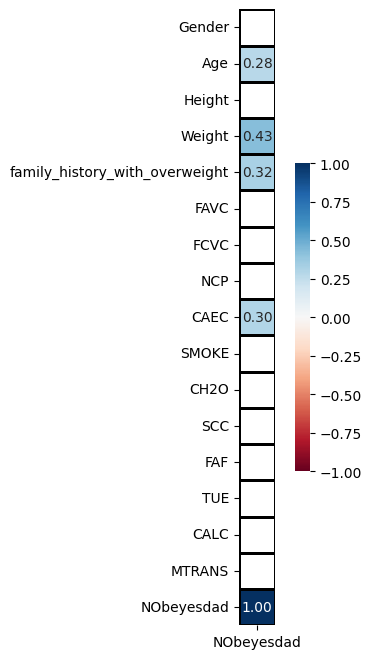

In [46]:
HeatmapPlot(train.corr()[[ 'NObeyesdad']], (5, 8), threshold=.25)

###### Prepare Test Set

In [47]:
test[categorical_columns] = ordinal_encoder.transform(test[categorical_columns])

In [48]:
test[categorical_columns] = test[categorical_columns].astype(int)

In [49]:
age_test = np.array(test['Age']).reshape(-1, 1)

In [50]:
test['Age']=scaler1.transform(age_test)

In [51]:
weight_test = np.array(test['Weight']).reshape(-1, 1)

In [52]:
test['Weight']=scaler2.transform(weight_test)

In [53]:
test['NCP'] = test['NCP'].astype(int)

In [54]:
test.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,1,0.523243,1.848294,1.246090,1,1,2.938616,3,2,0,2.825629,0,0.855400,0.000000,2,3
1,20759,0,-0.501895,1.600000,-0.826686,1,1,2.000000,1,2,0,3.000000,0,1.000000,0.000000,2,3
2,20760,0,0.366883,1.643355,0.903045,1,1,3.000000,3,2,0,2.621877,0,0.000000,0.250502,2,3
3,20761,1,-0.505500,1.553127,0.602188,1,1,2.000000,2,2,0,2.786417,0,0.094851,0.000000,2,3
4,20762,0,0.366883,1.627396,0.646426,1,1,3.000000,3,2,0,2.653531,0,0.000000,0.741069,2,3


In [55]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13840 non-null  int64  
 1   Gender                          13840 non-null  int64  
 2   Age                             13840 non-null  float64
 3   Height                          13840 non-null  float64
 4   Weight                          13840 non-null  float64
 5   family_history_with_overweight  13840 non-null  int64  
 6   FAVC                            13840 non-null  int64  
 7   FCVC                            13840 non-null  float64
 8   NCP                             13840 non-null  int64  
 9   CAEC                            13840 non-null  int64  
 10  SMOKE                           13840 non-null  int64  
 11  CH2O                            13840 non-null  float64
 12  SCC                             

##### Split Train Set

In [56]:
X=train.drop(['NObeyesdad'],axis=1)
y=train['NObeyesdad']

# 👽 **Models**

#### **Sumbmission** Function

In [57]:
def Sumbit(model, test, name='submission'):
    testx = test.drop('id',axis=1)
    pred = model.predict(testx)
    sub = pd.DataFrame({"id":test['id'], "NObeyesdad":pred})
    sub['NObeyesdad'] = lb.inverse_transform(pred)
    sub.to_csv(f"{name}.csv",index=False)

## **GradientBoostingClassifier Model**

 **i) Baseline Model Training**

In [58]:
model=GradientBoostingClassifier()

In [59]:
model.fit(X,y)

GradientBoostingClassifier()

In [60]:
y_cv_pred = cross_val_predict(model, X, y, cv=5,method='predict')

In [61]:
print(classification_report(y,y_cv_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2790
           1       0.88      0.88      0.88      3364
           2       0.90      0.89      0.89      3261
           3       0.96      0.97      0.97      3545
           4       1.00      1.00      1.00      4370
           5       0.81      0.78      0.80      2703
           6       0.81      0.83      0.82      2812

    accuracy                           0.91     22845
   macro avg       0.90      0.90      0.90     22845
weighted avg       0.91      0.91      0.91     22845



<Figure size 800x600 with 0 Axes>

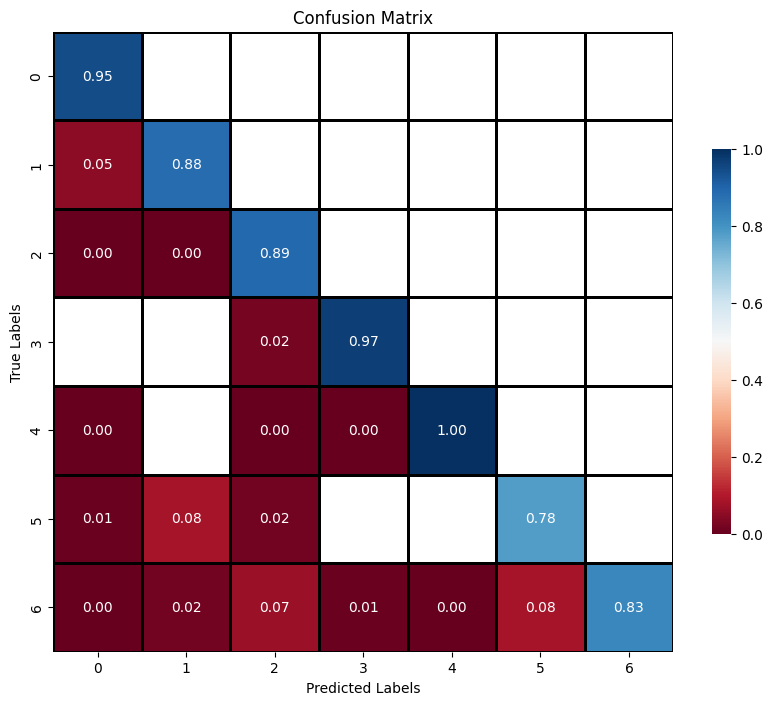

In [62]:
conf_matrix = confusion_matrix(y, y_cv_pred, normalize='true')
plt.figure(figsize=(8, 6))
HeatmapPlot(conf_matrix, center=.5, vmin=0)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix');

## **Extra Trees Classifier**

In [63]:
model2 = ExtraTreesClassifier()
model2.fit(X,y)
y_cv_pred2 = cross_val_predict(model2, X, y, cv=5,method='predict')
print(classification_report(y,y_cv_pred2))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2790
           1       0.82      0.87      0.84      3364
           2       0.88      0.87      0.87      3261
           3       0.96      0.97      0.97      3545
           4       1.00      1.00      1.00      4370
           5       0.77      0.69      0.73      2703
           6       0.77      0.79      0.78      2812

    accuracy                           0.88     22845
   macro avg       0.87      0.87      0.87     22845
weighted avg       0.88      0.88      0.88     22845



Text(0.5, 1.0, 'Confusion Matrix')

<Figure size 800x600 with 0 Axes>

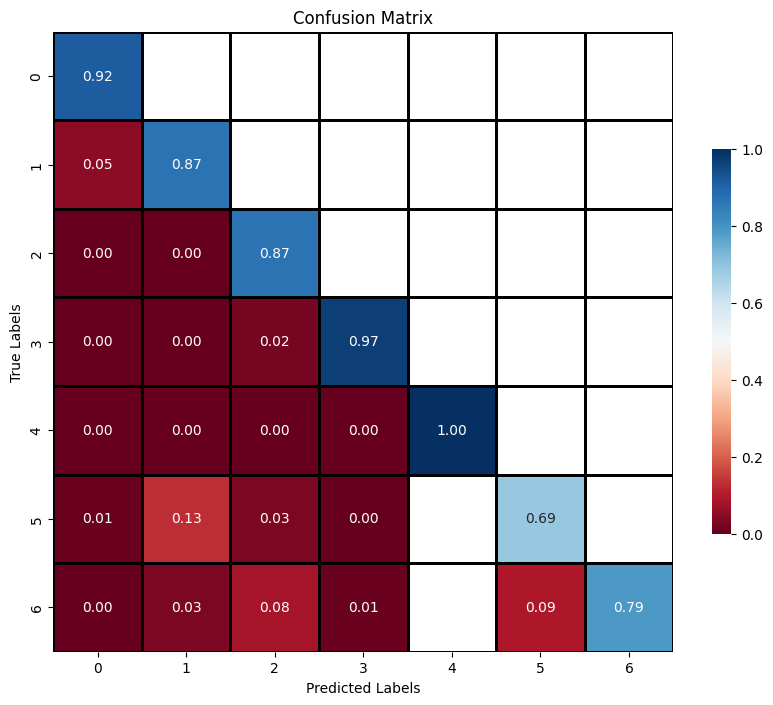

In [64]:
conf_matrix = confusion_matrix(y, y_cv_pred2, normalize='true')
plt.figure(figsize=(8, 6))
HeatmapPlot(conf_matrix, vmin=0, center=.5)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

## **SVC Model**

In [65]:
model_svc=SVC(C=100, kernel='rbf',random_state=42)

In [66]:
model_svc.fit(X,y)
y_cv_pred3 = cross_val_predict(model_svc, X, y, cv=5,method='predict')
print(classification_report(y,y_cv_pred3))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      2790
           1       0.85      0.83      0.84      3364
           2       0.87      0.87      0.87      3261
           3       0.96      0.97      0.96      3545
           4       1.00      1.00      1.00      4370
           5       0.75      0.72      0.73      2703
           6       0.76      0.77      0.77      2812

    accuracy                           0.88     22845
   macro avg       0.87      0.87      0.87     22845
weighted avg       0.88      0.88      0.88     22845



<Figure size 800x600 with 0 Axes>

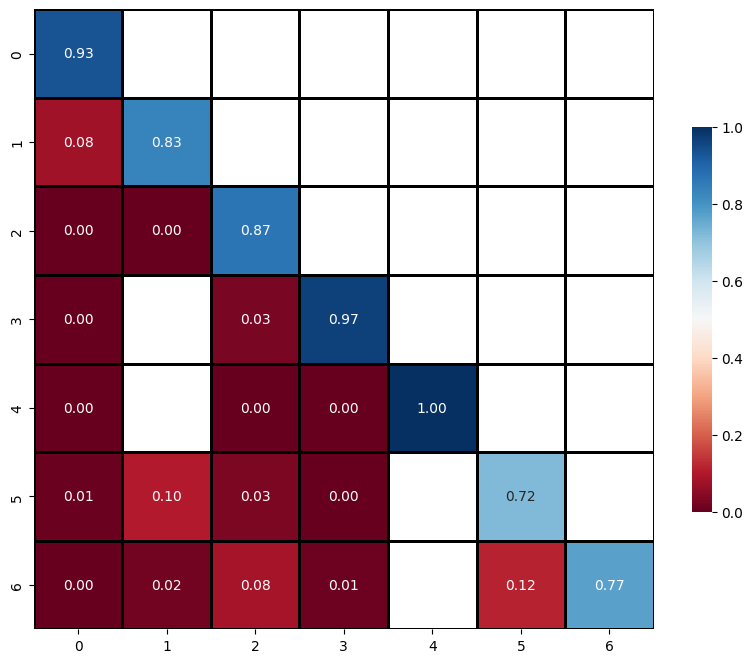

In [67]:
conf_matrix = confusion_matrix(y, y_cv_pred3, normalize='true')
plt.figure(figsize=(8, 6))
HeatmapPlot(conf_matrix, center=.5, vmin=0)

## **DecisionTree Classifier**

In [68]:
Decision_tree = DecisionTreeClassifier( criterion='entropy',max_depth=11,
                    min_samples_leaf=7, min_samples_split=18, random_state=42)

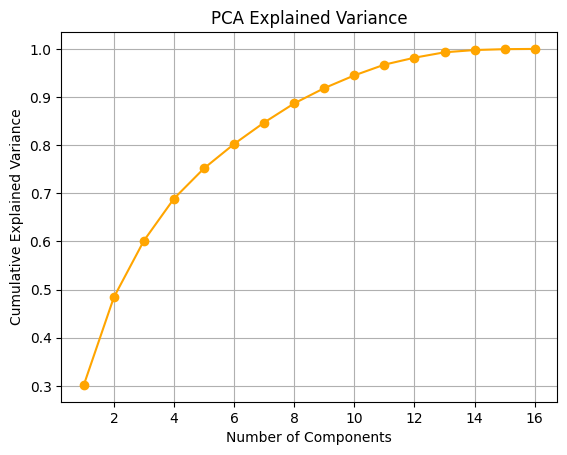

Optimal number of PCA components: 11


In [69]:
pca = PCA()
pca.fit(X)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

plt.plot(range(1, len(cumulative_explained_variance) + 1),
         cumulative_explained_variance, marker='o', color='orange')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()


optimal_num_components = np.where(cumulative_explained_variance >= 0.95 )[0][0] + 1

print(f"Optimal number of PCA components: {optimal_num_components}")

In [70]:
pca = PCA(n_components=optimal_num_components)
X_train_pca = pca.fit_transform(X)

In [71]:
def evaluate_model(clf, X, y):
    clf.fit(X, y)

    y_cv_pred3 = cross_val_predict(clf, X, y, cv=5,method='predict')

    print(classification_report(y,y_cv_pred3))
    conf_matrix = confusion_matrix(y, y_cv_pred3, normalize='true')

    # Print results
    plt.figure(figsize=(8, 6))

    HeatmapPlot(conf_matrix, center=.5, vmin=0)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')



    print('===========================')

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2790
           1       0.82      0.85      0.84      3364
           2       0.86      0.87      0.87      3261
           3       0.96      0.96      0.96      3545
           4       1.00      1.00      1.00      4370
           5       0.77      0.72      0.74      2703
           6       0.77      0.78      0.78      2812

    accuracy                           0.88     22845
   macro avg       0.87      0.87      0.87     22845
weighted avg       0.88      0.88      0.88     22845



<Figure size 800x600 with 0 Axes>

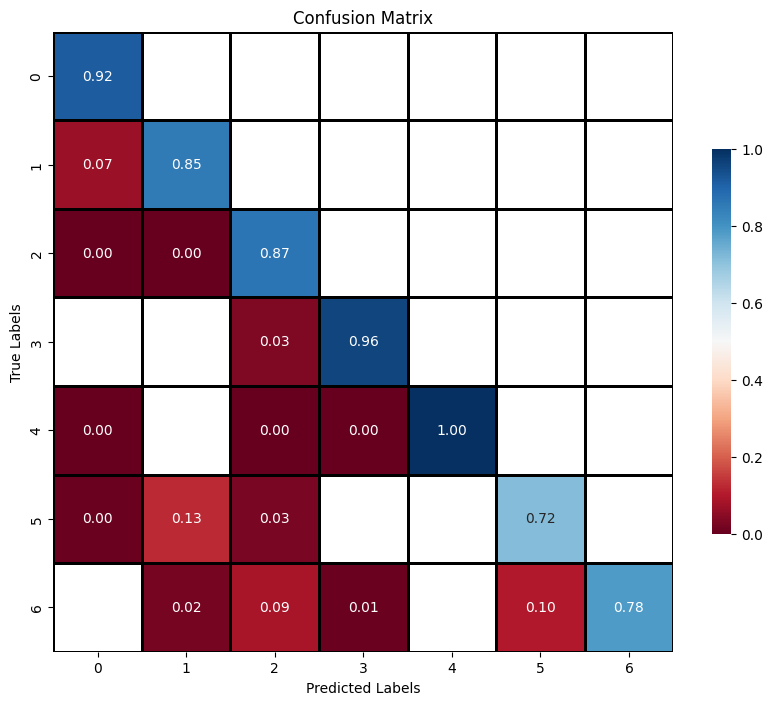

In [72]:
# decision tree without pca
evaluate_model(Decision_tree, X, y)

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      2790
           1       0.63      0.62      0.63      3364
           2       0.74      0.73      0.74      3261
           3       0.93      0.93      0.93      3545
           4       0.99      0.99      0.99      4370
           5       0.54      0.48      0.51      2703
           6       0.54      0.57      0.55      2812

    accuracy                           0.76     22845
   macro avg       0.73      0.74      0.73     22845
weighted avg       0.76      0.76      0.76     22845



<Figure size 800x600 with 0 Axes>

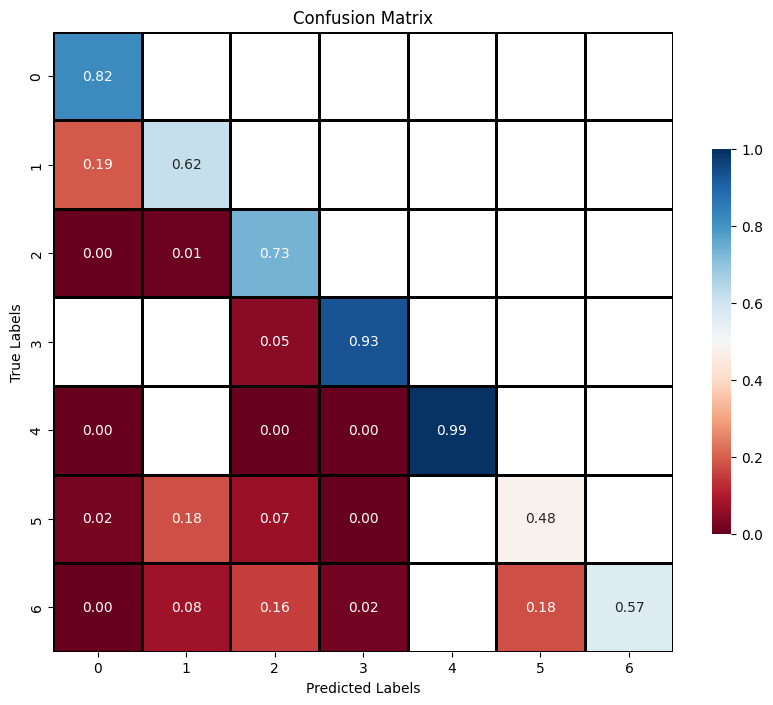

In [73]:
#decision tree with pca
evaluate_model(Decision_tree, X_train_pca, y)

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2790
           1       0.85      0.89      0.87      3364
           2       0.90      0.89      0.90      3261
           3       0.96      0.97      0.97      3545
           4       1.00      1.00      1.00      4370
           5       0.82      0.74      0.78      2703
           6       0.79      0.83      0.81      2812

    accuracy                           0.90     22845
   macro avg       0.89      0.89      0.89     22845
weighted avg       0.90      0.90      0.90     22845



<Figure size 800x600 with 0 Axes>

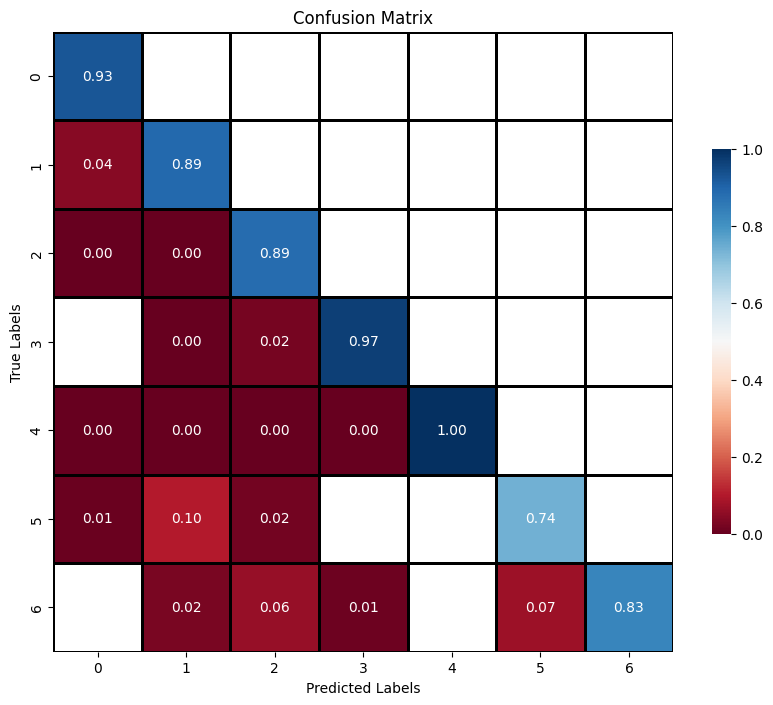

In [74]:
random_forest = RandomForestClassifier(n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_depth=12, criterion='entropy')
evaluate_model(random_forest, X, y)

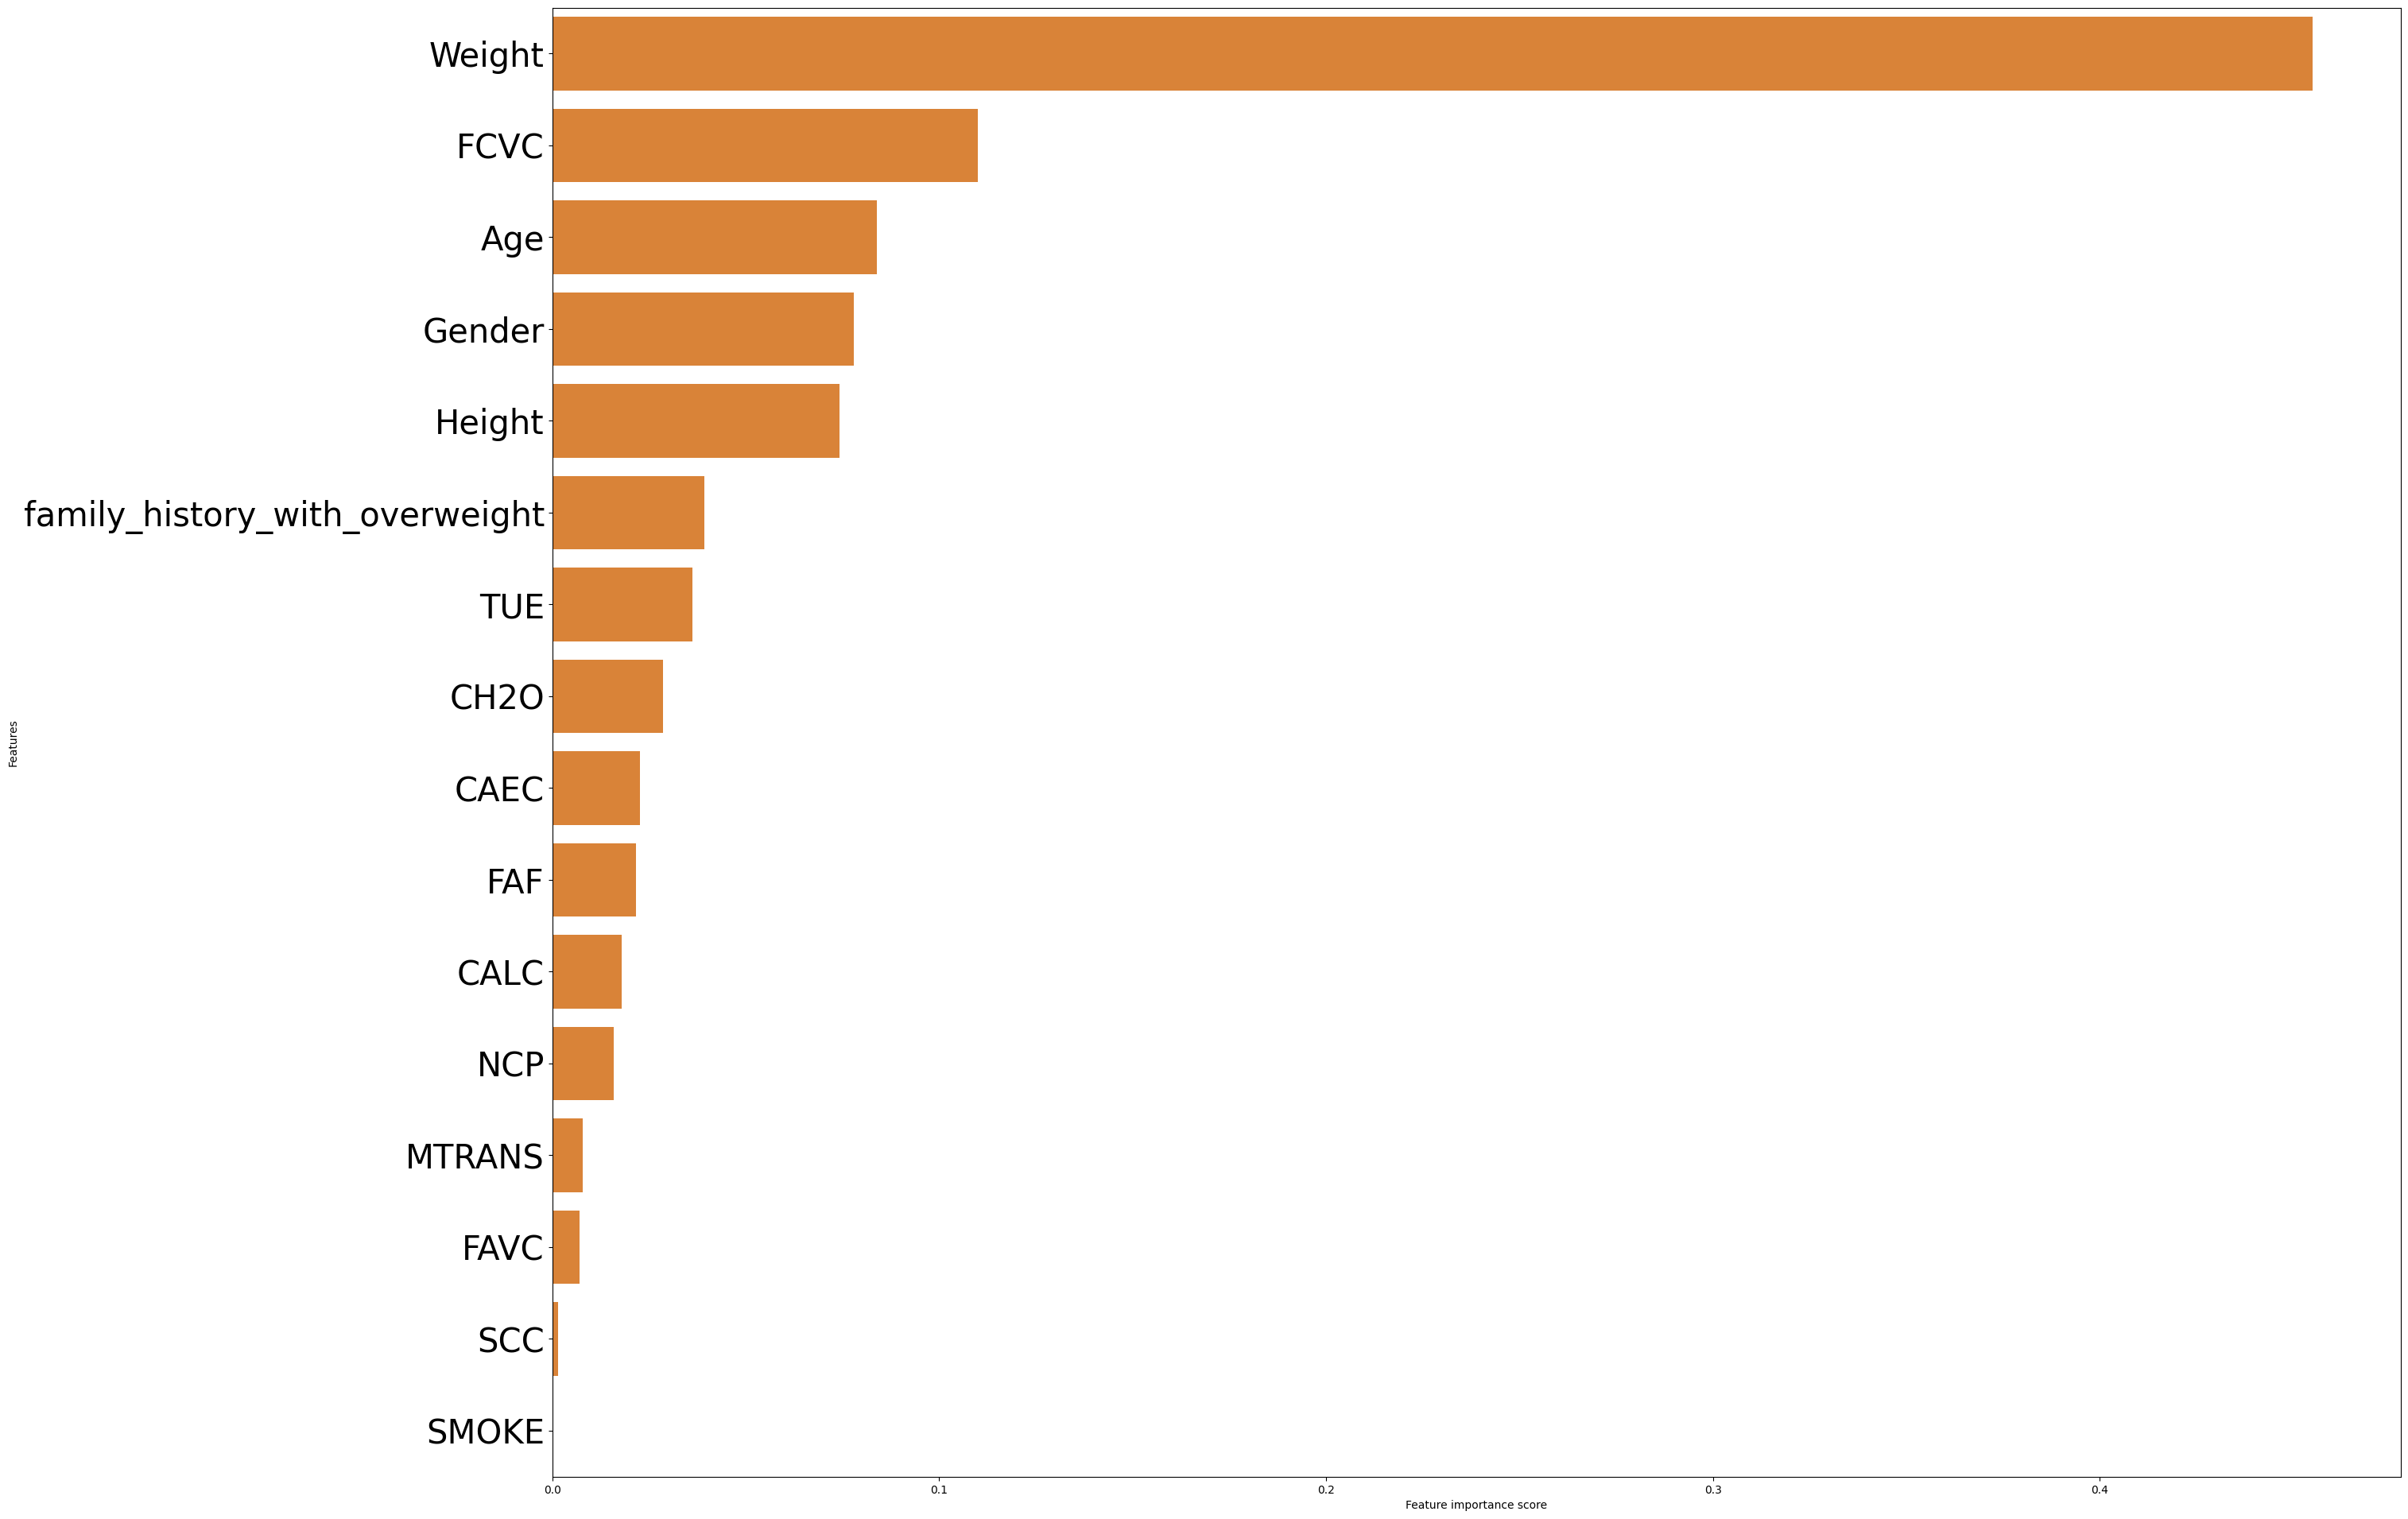

In [75]:
feature_scores = pd.Series(random_forest.feature_importances_, index=X.columns).sort_values(ascending=False)
TOP = 30
top_feature_scores = feature_scores[:TOP]
f, ax = plt.subplots(figsize=(30, 24))
sns.barplot(x=top_feature_scores, y=top_feature_scores.index,color=sns.color_palette('YlOrBr')[3])
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
ax.set_yticklabels(top_feature_scores.index, fontdict={'fontsize': 30})
plt.show()

In [76]:
Sumbit(random_forest, test, 'randomforest')

## **🚀XGBoost**
 [Documentaion](https://xgboost.readthedocs.io/en/stable/python/index.html)



In [77]:
xg_clf = xgb.XGBClassifier(n_estimators=300, max_depth=5, n_jobs=-1, seed=42, verbose=0, learning_rate=.5, gamma=1)
xg_clf.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [78]:
y_pred_train = xg_clf.predict(X)

print("🚀Classification Report On Train Dataset")
print(classification_report(y, y_pred_train))

🚀Classification Report On Train Dataset
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2790
           1       0.90      0.92      0.91      3364
           2       0.93      0.92      0.92      3261
           3       0.98      0.98      0.98      3545
           4       1.00      1.00      1.00      4370
           5       0.87      0.83      0.85      2703
           6       0.86      0.87      0.87      2812

    accuracy                           0.93     22845
   macro avg       0.93      0.93      0.93     22845
weighted avg       0.93      0.93      0.93     22845



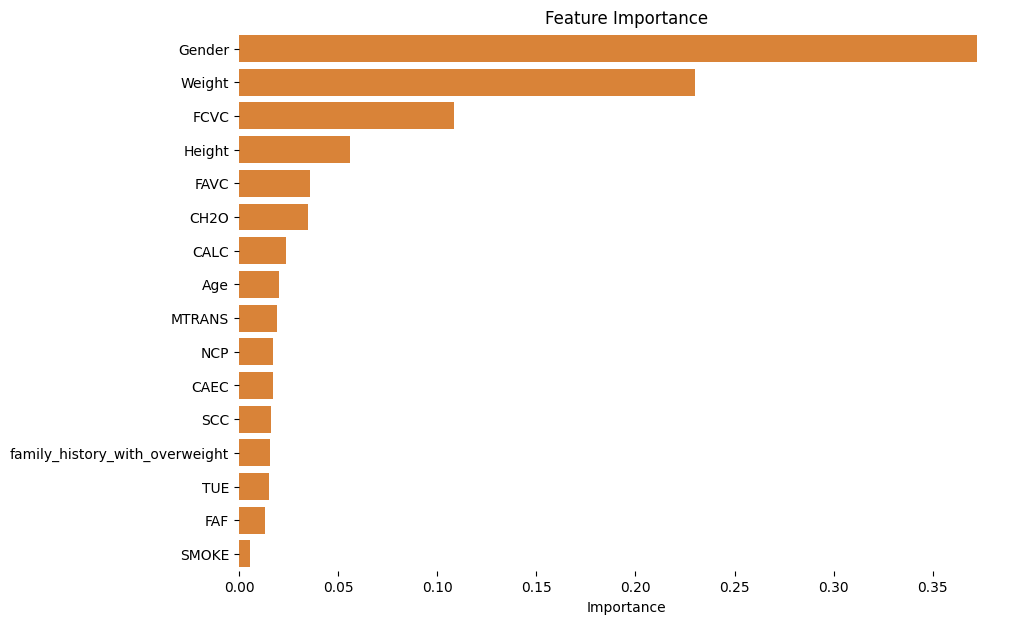

In [79]:
# feature importances
feature_importance = xg_clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color=sns.color_palette('YlOrBr')[3])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

In [80]:
Sumbit(xg_clf, test,'XGBClassifierBase')

#### CV


In [83]:
# churn_dmatrix = xgb.DMatrix(data=X, label=y)

# params={'objective' : 'multi:softmax', "max_depth":7, 'num_class' : y.nunique()}
# cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, nfold=10, stratified =True,
#     num_boost_round=200, metrics="merror", as_pandas=True, seed=42)

# print("Accuracy: %f" %((1-cv_results["test-merror-mean"]).iloc[-1]))

In [84]:
dmatrix = xgb.DMatrix(data=X, label=y)

gbm_param_grid = {'learning_rate': np.arange(0.1, 2.05, .15),
    'n_estimators': [100, 150, 200, 300],
    'subsample': np.arange(0.75,1.05,.05)}

gbm = xgb.XGBClassifier()

randomized_xgb = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid,
        n_iter=15, scoring='accuracy', cv=5, verbose=1)

randomized_xgb.fit(X, y)
print("Best parameters found: ",randomized_xgb.best_params_)
print("Best accuracy found: ", randomized_xgb.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters found:  {'subsample': 1.0000000000000002, 'n_estimators': 100, 'learning_rate': 0.1}
Best accuracy found:  0.9103961479536004


In [85]:
print(randomized_xgb.cv_results_['params'])

[{'subsample': 1.0500000000000003, 'n_estimators': 100, 'learning_rate': 1.9}, {'subsample': 1.0500000000000003, 'n_estimators': 200, 'learning_rate': 1.6}, {'subsample': 0.8500000000000001, 'n_estimators': 100, 'learning_rate': 0.9999999999999999}, {'subsample': 1.0000000000000002, 'n_estimators': 200, 'learning_rate': 1.9}, {'subsample': 1.0000000000000002, 'n_estimators': 100, 'learning_rate': 0.1}, {'subsample': 1.0500000000000003, 'n_estimators': 300, 'learning_rate': 1.9}, {'subsample': 1.0500000000000003, 'n_estimators': 200, 'learning_rate': 0.85}, {'subsample': 0.75, 'n_estimators': 150, 'learning_rate': 0.4}, {'subsample': 0.75, 'n_estimators': 100, 'learning_rate': 1.45}, {'subsample': 0.8500000000000001, 'n_estimators': 100, 'learning_rate': 0.85}, {'subsample': 1.0000000000000002, 'n_estimators': 300, 'learning_rate': 1.1500000000000001}, {'subsample': 0.9500000000000002, 'n_estimators': 150, 'learning_rate': 1.75}, {'subsample': 0.8500000000000001, 'n_estimators': 150, 'l

In [86]:
y_pred_train = randomized_xgb.predict(X)

print("🚀Classification Report On Train Dataset")
print(classification_report(y, y_pred_train))

🚀Classification Report On Train Dataset
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2790
           1       0.91      0.94      0.93      3364
           2       0.94      0.93      0.94      3261
           3       0.98      0.99      0.99      3545
           4       1.00      1.00      1.00      4370
           5       0.88      0.84      0.86      2703
           6       0.87      0.89      0.88      2812

    accuracy                           0.94     22845
   macro avg       0.94      0.94      0.94     22845
weighted avg       0.94      0.94      0.94     22845



In [87]:
best_xgb = randomized_xgb.best_estimator_

In [88]:
y_pred_train = best_xgb.predict(X)

print("🚀Classification Report On Train Dataset")
print(classification_report(y, y_pred_train))

🚀Classification Report On Train Dataset
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2790
           1       0.91      0.94      0.93      3364
           2       0.94      0.93      0.94      3261
           3       0.98      0.99      0.99      3545
           4       1.00      1.00      1.00      4370
           5       0.88      0.84      0.86      2703
           6       0.87      0.89      0.88      2812

    accuracy                           0.94     22845
   macro avg       0.94      0.94      0.94     22845
weighted avg       0.94      0.94      0.94     22845



In [89]:
Sumbit(best_xgb, test,'XGBClassifierBest')

## **🚀LightGBM**

  [Documentaion](https://lightgbm.readthedocs.io/en/stable/index.html)

In [90]:
lbm_clf = lgbm.LGBMClassifier(n_jobs=-1, verbose=0)
lbm_clf.fit(X, y)

LGBMClassifier(n_jobs=-1, verbose=0)

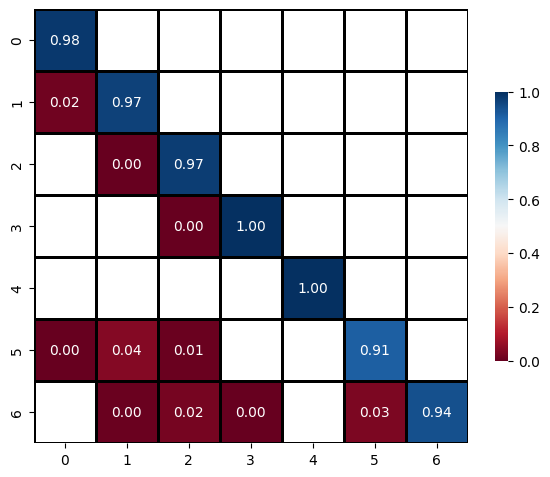

In [91]:
y_pred_test = lbm_clf.predict(X)
conf_matrix = confusion_matrix(y, y_pred_test, normalize='true')

HeatmapPlot(conf_matrix, (7, 7), vmin=0, center=.5)

In [92]:
y_pred_train = lbm_clf.predict(X)

print("🚀Classification Report On Train Dataset")
print(classification_report(y, y_pred_train))

🚀Classification Report On Train Dataset
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2790
           1       0.95      0.97      0.96      3364
           2       0.97      0.97      0.97      3261
           3       1.00      1.00      1.00      3545
           4       1.00      1.00      1.00      4370
           5       0.94      0.91      0.93      2703
           6       0.94      0.94      0.94      2812

    accuracy                           0.97     22845
   macro avg       0.97      0.97      0.97     22845
weighted avg       0.97      0.97      0.97     22845



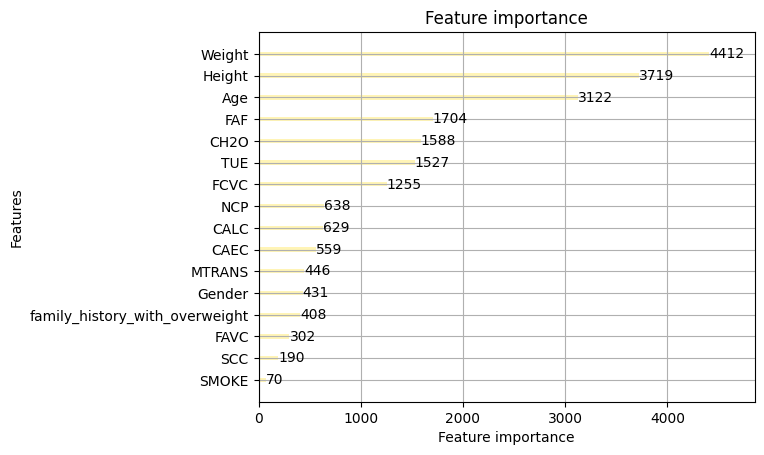

In [93]:
lgbm.plot_importance(lbm_clf);

In [94]:
Sumbit(lbm_clf, test,'LGBMClassifierBase')

#### Tuning


In [95]:
import optuna.integration.lightgbm as lgb

from lightgbm import early_stopping
from lightgbm import log_evaluation



if __name__ == "__main__":

    dtrain = lgb.Dataset(X, label=y)
    dval = lgb.Dataset(X, label=y)

    params = {
        "objective": "multiclass",
        "metric": "multi_error",
        # "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "num_class": 7,
    }

    # mod_lgbm = lgb.train(
    #     params,
    #     dtrain,
    #     valid_sets=[dtrain, dval],
    #     callbacks=[early_stopping(100), log_evaluation(100)],
    # )


In [96]:
    # prediction = mod_lgbm.predict(X, num_iteration=mod_lgbm.best_iteration).argmax(axis=1)
    # print(prediction.shape, prediction)
    # accuracy = classification_report(y, prediction)

    # best_params = mod_lgbm.params
    # print("Best params:", best_params)
    # print("  Accuracy = {}".format(accuracy))
    # print("  Params: ")
    # for key, value in best_params.items():
    #     print("    {}: {}".format(key, value))

In [97]:
best_params = {'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 7,
    'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 42,
    'learning_rate': 0.0327621905857854208, 'n_estimators': 500,
    'lambda_l1': 0.009879324515507773, 'lambda_l2': 0.045092765238180027,
    'max_depth': 10, 'colsample_bytree': 0.451686663982718,
    'subsample': 0.9636469087931024, 'min_child_samples': 28}

best_lgb = lgbm.LGBMClassifier(**best_params, n_jobs=-1)

In [98]:
best_lgb.fit(X, y)

LGBMClassifier(colsample_bytree=0.451686663982718,
               lambda_l1=0.009879324515507774, lambda_l2=0.045092765238180024,
               learning_rate=0.032762190585785424, max_depth=10,
               metric='multi_logloss', min_child_samples=28, n_estimators=500,
               n_jobs=-1, num_class=7, objective='multiclass', random_state=42,
               subsample=0.9636469087931024, verbosity=-1)

In [99]:
Sumbit(best_lgb, test, 'LGBMClassificationBest')

In [100]:
y_pred_train = best_lgb.predict(X)

print("🚀Classification Report On Train Dataset")
print(classification_report(y, y_pred_train))

🚀Classification Report On Train Dataset
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2790
           1       0.95      0.97      0.96      3364
           2       0.98      0.98      0.98      3261
           3       1.00      1.00      1.00      3545
           4       1.00      1.00      1.00      4370
           5       0.95      0.92      0.93      2703
           6       0.95      0.95      0.95      2812

    accuracy                           0.98     22845
   macro avg       0.97      0.97      0.97     22845
weighted avg       0.98      0.98      0.98     22845



## **🚀CatBoost**

[Documentation](https://catboost.ai/)

In [101]:
cat_clf = cb.CatBoostClassifier(verbose=0)
cat_clf.fit(X, y)

In [102]:
y_pred_train = cat_clf.predict(X)

print("🚀Classification Report On Train Dataset")
print(classification_report(y, y_pred_train))

🚀Classification Report On Train Dataset
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2790
           1       0.94      0.95      0.95      3364
           2       0.95      0.94      0.95      3261
           3       0.98      0.99      0.99      3545
           4       1.00      1.00      1.00      4370
           5       0.92      0.88      0.90      2703
           6       0.90      0.92      0.91      2812

    accuracy                           0.96     22845
   macro avg       0.95      0.95      0.95     22845
weighted avg       0.96      0.96      0.96     22845



## **🚀Voting**

In [104]:
estimators = [('xgb' , xg_clf),
                ('lgb', lbm_clf),
                ('svc', model_svc),
                ('extra', model2),
                ('lr', LogisticRegression()),
                ('rf', RandomForestClassifier())
                ]
v_clf = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

v_clf.fit(X, y)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=1,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('lgb', LGBMClassifier(n_jobs=-1, verbose=0)),
                             ('svc', SVC(C=100, random_state=42)),
                             ('extra', ExtraTreesClassifier()),
                             ('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier())],
                 n_jobs=-1)

In [105]:
v_pred = v_clf.predict(X)

print("🚀Classification Report On Train Dataset")
print(classification_report(y, v_pred))

🚀Classification Report On Train Dataset
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2790
           1       0.95      0.96      0.96      3364
           2       0.96      0.98      0.97      3261
           3       1.00      0.99      0.99      3545
           4       1.00      1.00      1.00      4370
           5       0.95      0.92      0.93      2703
           6       0.96      0.93      0.95      2812

    accuracy                           0.97     22845
   macro avg       0.97      0.97      0.97     22845
weighted avg       0.97      0.97      0.97     22845



In [106]:
Sumbit(v_clf, test,'VotingClassifier')

## **🚀Stacking**



In [107]:
estimators = [('xgb' , xg_clf),
                ('lgb', lbm_clf),
                # ('cb', cat_clf),
                ('svc', model_svc),
                ('extra', model2),
                ('lr', LogisticRegression()),
                ('rf', RandomForestClassifier())
                ]
stack_clf = StackingClassifier(estimators=estimators, final_estimator=best_lgb,
                         cv=StratifiedKFold(5, shuffle=True, random_state=42), n_jobs=-1)

stack_clf.fit(X, y)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=1,
                                              grow_policy=None,
                                              im...
                   final_estimator=LGBMClassifier(colsample_bytree=0.451686663982718,
                                                  lambda_l1=0.009879324515507774,
                                                  lambda_l2=0.045092765238180024,
                                                  learning_rate=0.032762190585785424,
                                                  max_depth=10,
                                                  metric='multi_logloss',
                                                  min_child_samples=28,
                                                  n_estimators=500, n_jobs=-1,
                                                  num_class=7,
                                                  objective='multiclass',
                                                  random_state=42,
                                                  subsample=0.9636469087931024,
                                                  verbosity=-1),
                   n_jobs=-1)

In [108]:
y_pred_train = stack_clf.predict(X)

print("🚀Classification Report On Train Dataset")
print(classification_report(y, y_pred_train))

🚀Classification Report On Train Dataset
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2790
           1       0.96      0.96      0.96      3364
           2       0.98      0.97      0.97      3261
           3       0.99      0.99      0.99      3545
           4       1.00      1.00      1.00      4370
           5       0.90      0.87      0.88      2703
           6       0.90      0.93      0.91      2812

    accuracy                           0.96     22845
   macro avg       0.96      0.96      0.96     22845
weighted avg       0.96      0.96      0.96     22845



In [109]:
Sumbit(stack_clf, test, 'StackingClassifier')